In [24]:
import numpy as np
import pandas as pd
import os
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import zoom
#from soma import aims

In [25]:
def get_neighbors(skels, value):

    list_convolved_skels = []
    for skel in skels:
        skel_simple = (skel == value).astype(int)
        # Convolve over all three axes in a for loop
        k = np.array([[[1,1,1],
                    [1,1,1],
                    [1,1,1]],
                    [[1,1,1],
                    [1,1,1],
                    [1,1,1]],
                    [[1,1,1],
                    [1,1,1],
                    [1,1,1]]])
        convolved_skel = ndimage.convolve(skel_simple, k, mode='constant', cval=0.0)
        list_convolved_skels.append(convolved_skel)
    
    return list_convolved_skels


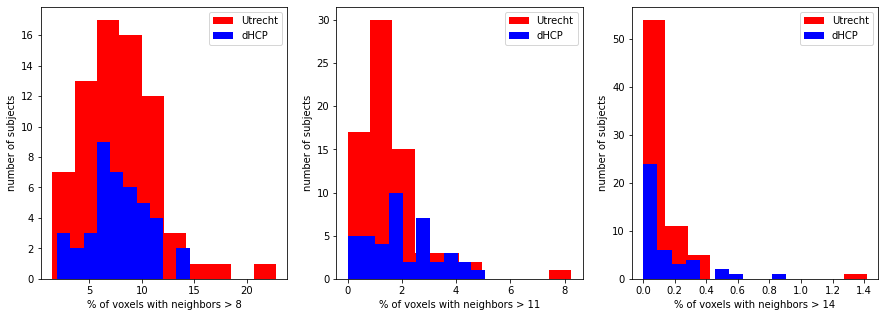

In [26]:
# Utrecht and dHCP

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/utrecht_dHCP/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    axs[idx].hist(proportion_wrong_thickness[:71], color='r', label='Utrecht')
    axs[idx].hist(proportion_wrong_thickness[71:], color='b', label='dHCP')
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [27]:
# in Utrecht / dHCP, use the threshold to create a classifier and measure AUC

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/utrecht_dHCP/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'

skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)
labels = [0 for k in range(71)] + [1 for k in range(41)]

for threshold in range(1, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 1: 0.3562349708004123
threshold 2: 0.4081071796633459
threshold 3: 0.4297492270697355
threshold 4: 0.4264857437306767
threshold 5: 0.42287873582961183
threshold 6: 0.4366197183098592
threshold 7: 0.47028512538646516
threshold 8: 0.4630711095843353
threshold 9: 0.49124012366884234
threshold 10: 0.518722088629337
threshold 11: 0.58055650979045
threshold 12: 0.6326004809343868
threshold 13: 0.6420474063895569
threshold 14: 0.5822741326004809
threshold 15: 0.5884575747165922
threshold 16: 0.5743730676743387
threshold 17: 0.48917897629680523


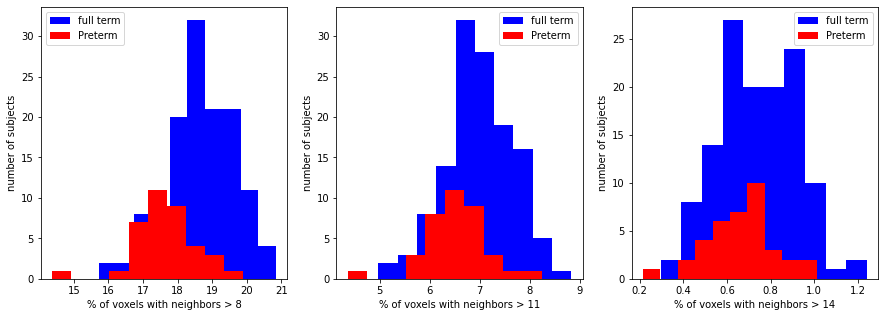

In [28]:
# new dHCP_165 data

dir_skels = '/neurospin/dico/jlaval/data/dHCP_165/skels.npy'
dir_names = '/neurospin/dico/jlaval/data/dHCP_165/names.npy'
labels_dir = '/neurospin/dico/jlaval/data/labels_dHCP.csv'
df_labels = pd.read_csv(labels_dir, sep=',')
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
names = np.load(dir_names)
labels = [df_labels.loc[df_labels['Subject']==name]['Preterm'].tolist()[0] for name in names]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    proportion_wrong_thickness_preterm = [elem for idx, elem in enumerate(proportion_wrong_thickness) if labels[idx]]
    proportion_wrong_thickness_full_term = [elem for idx, elem in enumerate(proportion_wrong_thickness) if not labels[idx]]

    axs[idx].hist(proportion_wrong_thickness_full_term, color='b', label='full term')
    axs[idx].hist(proportion_wrong_thickness_preterm, color='r', label='Preterm')
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [30]:
skels.shape

(165, 96, 114, 96)

In [29]:
# measure AUC depending on threshold

for threshold in range(1, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=0)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 1: 0.7557010135135136
threshold 2: 0.8053209459459459
threshold 3: 0.8141891891891891
threshold 4: 0.8215793918918919
threshold 5: 0.8203125
threshold 6: 0.8190456081081081
threshold 7: 0.8141891891891893
threshold 8: 0.8065878378378378
threshold 9: 0.7991976351351351
threshold 10: 0.788429054054054
threshold 11: 0.7565456081081081
threshold 12: 0.7088260135135136
threshold 13: 0.6763091216216216
threshold 14: 0.6321790540540541
threshold 15: 0.6053631756756755
threshold 16: 0.5948057432432432
threshold 17: 0.604518581081081


A simple convolution followed by a sum of pixels over threshold gives an AUC of 0.64 again.. Threshold 1 simply reflects the differences in volume, whereas threshold > 9 are the effect of resampling (of course linked to volume, but in theory in an opposite way). The inversion of the AUC is observed in Utrecht / dHCP but not in dHCP_165.

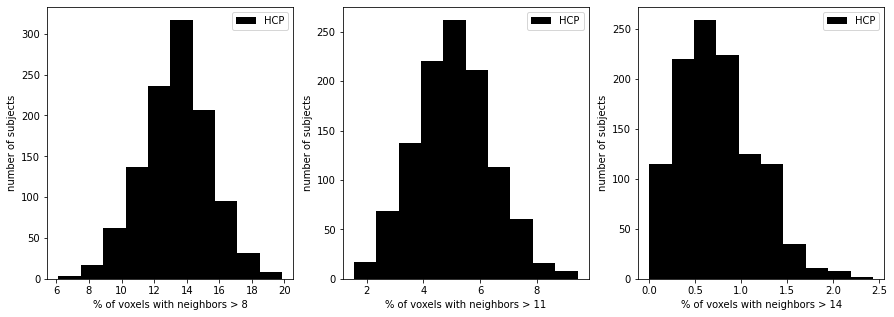

In [4]:
# HCP : is the thickness still there ?

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
label='HCP'
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    axs[idx].hist(proportion_wrong_thickness, color='k', label=label)
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

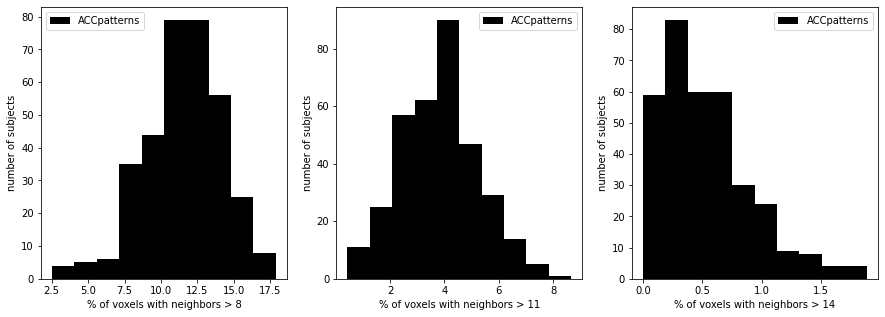

In [5]:
# ACC patterns

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
label = 'ACCpatterns'
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    axs[idx].hist(proportion_wrong_thickness, color='k', label=label)
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [7]:
# Compare to ACCpatterns Right PCS

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'

skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)

# get Right PCS label
labels = []
labels_df = pd.read_csv('/neurospin/dico/data/deep_folding/papers/miccai2023/Input/csv/ACCpatterns/all.csv', dtype=str, usecols=['long_name', 'Right_PCS'])
subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()
for name in subjects:
    df_row = labels_df.loc[labels_df['long_name']==name]
    lab = df_row['Right_PCS'].tolist()[0]
    labels.append(lab!='present')

for threshold in range(9, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 9: 0.5808833897349126
threshold 10: 0.5915820642978004
threshold 11: 0.5985265087422448
threshold 12: 0.6018753525098703
threshold 13: 0.5946489001692048
threshold 14: 0.5853426395939086
threshold 15: 0.5957064297800339
threshold 16: 0.6041137901861252
threshold 17: 0.5862415397631133


Even on ACCpatterns there's a bias for classification of RightPCS!

In [15]:
# create npy files from nifti raw skels
# 100 samples is enough
dir_raw = '/neurospin/dico/data/deep_folding/current/datasets/hcp/skeletons/raw/R/'
files = [f for f in os.listdir(dir_raw) if f[-6:]=='nii.gz']
for idx, file in enumerate(files):
    a = aims.read(dir_raw+file)
    b = a.np
    c = b == 60
    name = file[-13:-7]
    np.save(f'/neurospin/dico/jlaval/data/HCP/raw_skel_{name}.npy',c)
    if idx == 100:
        break

/home/jl274628/Runs/02_deep_supervised/Program/2023_agaudin_jchavas_folding_supervised/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


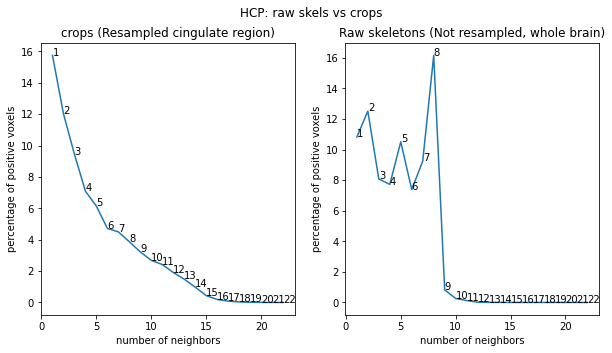

In [11]:
# control : plot the histograms of the number of neighbours in raw skels vs crops
# Use HCP
samples=4
mini=1

plt.close()
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# crops
dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)
convolved_skels = np.array(list_convolved_skels)

hist_neighbors = convolved_skels.flatten()
maxi = np.max(hist_neighbors)
hist = []
for k in range(1, maxi+1):
    nb = np.sum(hist_neighbors == k)
    hist.append(nb)
hist = 100 * np.array(hist) / sum(hist)
truncated_hist = hist[mini:]
x_list = range(mini, maxi)
axs[0].plot(x_list, truncated_hist)
for x,y in zip(x_list, truncated_hist): 
    axs[0].text(x, y, str(x))
axs[0].set_ylabel('percentage of positive voxels')
axs[0].set_xlabel('number of neighbors')
axs[0].set_title('crops (Resampled cingulate region)')

# raw skels
dir_raw = '/neurospin/dico/jlaval/data/HCP/'
files = [f for f in os.listdir(dir_raw)]
raw = []
for idx,file in enumerate(files):
    raw_skel = np.load(dir_raw+file)
    raw_skel = raw_skel[:,:,:,0]
    raw.append(raw_skel)
    if idx >= samples-1:
        break
raw = np.array(raw, dtype=object)
list_convolved_skels = get_neighbors(raw, True) # already simple surfaces only
convolved_skels = np.array(list_convolved_skels)

hist_neighbors_list = []
for im in convolved_skels: # flatten each image here because the dimensions are different
    hist_neighbors_list.append(im.flatten())
hist_neighbors = np.hstack(hist_neighbors_list)
hist = []
for k in range(1, maxi+1):
    nb = np.sum(hist_neighbors == k)
    hist.append(nb)
hist = 100 * np.array(hist) / sum(hist)
truncated_hist = hist[mini:]
x_list = range(mini, maxi)
axs[1].plot(x_list, truncated_hist)
for x,y in zip(x_list, truncated_hist): 
    axs[1].text(x, y, str(x))
axs[1].set_ylabel('percentage of positive voxels')
axs[1].set_xlabel('number of neighbors')
axs[1].set_title('Raw skeletons (Not resampled, whole brain)')

plt.suptitle('HCP: raw skels vs crops')
plt.show()

# import nifti files ? Or convert to numpy before in shell : take simple surfaces too
# plot proportion instead of raw numbers

In [14]:
# test 3D convolution
a = np.array([[[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]],
              [[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]],
              [[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]]])

k = np.array([[[1,1,1],
              [1,1,1],
              [1,1,1]],
              [[1,1,1],
              [1,1,1],
              [1,1,1]],
              [[1,1,1],
              [1,1,1],
              [1,1,1]]])
ndimage.convolve(a, k, mode='constant', cval=0.0)

array([[[22, 22, 18,  8],
        [22, 22, 32, 22],
        [40, 40, 34, 22],
        [24, 24, 20, 14]],

       [[33, 33, 27, 12],
        [33, 33, 48, 33],
        [60, 60, 51, 33],
        [36, 36, 30, 21]],

       [[22, 22, 18,  8],
        [22, 22, 32, 22],
        [40, 40, 34, 22],
        [24, 24, 20, 14]]])

In [18]:
# understanding zoom function

input = np.random.rand(10,10)
output_shape=(30,30)
zoom_div = np.array(output_shape, float) - 1
zoom_ = np.divide(np.array(input.shape) - 1, zoom_div,
                    out=np.ones_like(input.shape, dtype=np.float64),
                    where=zoom_div != 0)

In [20]:
print(zoom_)
print(9/29)

[0.31034483 0.31034483]
0.3103448275862069
